In [1]:
### General analysis package
import os
import time
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm, pearsonr, spearmanr
from scipy.spatial import distance
### Drawing package
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
#import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # Output editable PDF text
### else
#import cloudpickle as pickle
import warnings
warnings.filterwarnings("ignore") # Error alert
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all' #last_expr

In [2]:
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, balanced_accuracy_score, recall_score, precision_score, roc_auc_score, average_precision_score

import math
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as TorchData
from torchmetrics import Accuracy
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from imblearn.over_sampling import RandomOverSampler, SMOTE

import warnings
warnings.filterwarnings('ignore')

SEED = 42
seed_everything(SEED, workers=True)

print("Using torch", torch.__version__)

Global seed set to 42


42

Using torch 1.10.1


In [3]:
class MaskedModel(LightningModule):
    def __init__(self, mirN, geneN, gene_mask, moduleN, module_mask, pathwayN, pathway_mask, learning_rate):
        super(MaskedModel, self).__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        # microRNA 2 Gene
        self.mir2gene = nn.Linear(mirN, geneN)
        self.mir2gene.weight.data = self.mir2gene.weight * gene_mask
        self.gene_mask = gene_mask
        self.gene_active = nn.ReLU() # ReLU Tanh
        self.gene_bn = nn.BatchNorm1d(geneN, eps=1e-05, momentum=0.5, affine=True)
        self.gene_dropout = nn.Dropout(p=0.8)
        
        ## Gene 2 Module
        self.gene2module = nn.Linear(geneN, moduleN)
        self.gene2module.weight.data = self.gene2module.weight * module_mask
        self.module_mask = module_mask
        self.module_active = nn.ReLU()
        self.module_bn = nn.BatchNorm1d(moduleN, eps=1e-05, momentum=0.5, affine=True)
        self.module_dropout = nn.Dropout(p=0.5)
        
        ## Module 2 Pathway
        self.module2pathway = nn.Linear(moduleN, pathwayN)
        self.module2pathway.weight.data = self.module2pathway.weight * pathway_mask
        self.pathway_mask = pathway_mask
        self.pathway_active = nn.ReLU()
        self.pathway_bn = nn.BatchNorm1d(pathwayN, eps=1e-05, momentum=0.5, affine=True)
        self.pathway_dropout = nn.Dropout(p=0.2)
        
        ## Output
        self.pathway2out = nn.Linear(pathwayN, 2)
        self.out_bn = nn.BatchNorm1d(2, eps=1e-05, momentum=0.5, affine=True)
        #self.sigmoid = nn.Sigmoid()
        
        # Result save
        self.gene_result = None
        self.module_result = None
        self.pathway_result = None
    
    def forward(self, x):
        ## microRNA 2 Gene
        #print(self.mir2gene.weight.data.shape, self.mir2gene.weight.shape, self.gene_mask.shape)
        self.mir2gene.weight.data = self.mir2gene.weight * self.gene_mask
        #print(self.mir2gene.weight.data.shape)
        gene_x = self.mir2gene(x)
        gene_x = self.gene_active(gene_x)
        gene_x = self.gene_bn(gene_x)
        gene_x = self.gene_dropout(gene_x)
        self.gene_result = gene_x # save result
        
        ## Gene 2 Module
        self.gene2module.weight.data = self.gene2module.weight * self.module_mask
        module_x = self.gene2module(gene_x)
        module_x = self.module_active(module_x)
        module_x = self.module_bn(module_x)
        module_x = self.module_dropout(module_x)
        self.module_result = module_x # save result
        
        ## Module 2 Pathway
        self.module2pathway.weight.data = self.module2pathway.weight * self.pathway_mask
        pathway_x = self.module2pathway(module_x)
        pathway_x = self.pathway_active(pathway_x)
        pathway_x = self.pathway_bn(pathway_x)
        pathway_x = self.pathway_dropout(pathway_x)
        self.pathway_result = pathway_x # save result
        
        ## Output
        out_x = self.pathway2out(pathway_x)
        out_x = self.out_bn(out_x)
        #out_x = self.sigmoid(out_x)
        return out_x
    
    def training_step(self, batch, batch_nb):
        x, y = batch
        loss = F.cross_entropy(self.forward(x), y)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = F.softmax(self(x))
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = logits[:, 1]
        auc = roc_auc_score(y, probs)
        bac = balanced_accuracy_score(y, preds)
        aps = average_precision_score(y, probs)
        recall = recall_score(y, preds)
        precision = precision_score(y, preds)
        #self.auc(probs, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_bac", bac, prog_bar=True)
        self.log("val_auc", auc, prog_bar=True)
        self.log("val_aps", aps, prog_bar=True)
        self.log("val_rec", recall, prog_bar=True)
        self.log("val_pre", precision, prog_bar=True)
        return loss
    
    def validation_epoch_end(self, validation_step_outputs):
        avg_loss = torch.stack(validation_step_outputs).mean()
        #avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean() # Outputs are the values of return for validation
        self.logger.experiment.add_scalar('loss', avg_loss, self.current_epoch)
    
    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = F.softmax(self(x))
        loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        probs = logits[:, 1]
        return preds, probs

In [4]:
microRNA = pd.read_csv('20220610_Results/1. diff_microRNA(FC2_FDR0.05).csv', index_col=0)['ID']

In [5]:
import cloudpickle as pickle
[mir2gene, GENE_LIST, GENE_MASK, gene2module, MODULE_LIST, MODULE_MASK,
 module2pathway, PATHWAY_LIST, PATHWAY_MASK] = pickle.load(open('20220610_Results/6. KEGG_MappingData.pkl', 'rb'))

In [6]:
model = MaskedModel.load_from_checkpoint(checkpoint_path="Temp/BioNet_SMOTE_val_loss.ckpt")
trainer = Trainer()
#trainer.test(model, dataloaders=test_data_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
extenal = pd.read_csv('20220610_Results/1. GSE58606.csv', index_col=0)
X_train_ = pd.read_csv('20220610_Results/1. X_train.csv', index_col=0)
len(microRNA), len(set(microRNA)&set(extenal.columns))
extenal.head(2)
temp = extenal[list(set(microRNA)&set(extenal.columns))+['Label']]
for i in set(microRNA)-set(extenal.columns):
    temp[i] = X_train_[i].mean()
extenal = temp
extenal.head(2)

(710, 523)

,hsa-miR-9-5p,hsa-miR-126-3p,hsa-miR-140-5p,hsa-miR-105-5p,hsa-miR-297,hsa-let-7i-5p,hsa-miR-130a-3p,hsa-miR-146b-5p,hsa_negative_control_6,hsa_negative_control_7,...,hsa-miR-205-3p,hsa-miR-1260a,hsa-miR-525-5p,hsa-miR-187-5p,hsa-miRPlus-A1086,hsa-miR-551b-5p,hsa-miR-300,hsa-miR-193b-5p,Label,Disease
0,6.877643,8.080215,6.245265,6.304782,6.686064,7.805950,6.814781,7.146955,6.170680,6.129586,...,7.176684,7.724408,6.035476,6.255048,6.572019,6.251777,5.873303,6.362097,1,primary breast cancer
1,6.544287,6.882722,5.874236,6.324987,6.638048,6.946567,6.488574,6.690773,6.160272,6.104929,...,7.249094,7.308890,6.021796,6.902473,6.347183,6.625569,6.004899,6.560329,1,primary breast cancer


,hsa-miR-3926,hsa-miR-4267,hsa-miR-548ak,hsa-miR-5701,hsa-miR-4304,hsa-miR-143-3p,hsa-miR-4781-3p,hsa-miR-483-5p,hsa-miR-3622b-5p,hsa-miR-4803,...,hsa-miR-6720-3p,hsa-miR-7641,hsa-miR-1252-3p,hsa-miR-6129,hsa-miR-520g-5p,hsa-miR-670-5p,hsa-miR-6841-3p,hsa-miR-6734-5p,hsa-miR-6514-5p,hsa-miR-7974
0,6.379868,6.353834,5.868474,8.628912,6.183578,8.401114,5.895089,7.873301,6.428665,6.128846,...,2.613294,6.056884,2.626683,2.796097,2.627649,2.815612,3.03934,3.849228,2.654754,2.949888
1,6.547309,6.338348,5.856222,7.647449,6.477872,6.916796,5.913144,7.513173,6.366013,6.146907,...,2.613294,6.056884,2.626683,2.796097,2.627649,2.815612,3.03934,3.849228,2.654754,2.949888


In [8]:
X_extenal = torch.from_numpy(extenal[microRNA].values).type(torch.FloatTensor)
y_extenal = torch.from_numpy(extenal['Label'].values).type(torch.LongTensor)
extenal_data_loader = TorchData.DataLoader(dataset=TorchData.TensorDataset(X_extenal, y_extenal), 
                                           batch_size=X_extenal.shape[0], shuffle=False)

In [9]:
#trainer.test(model, extenal_data_loader)

# Migration Learning (3 layers before freezing: 3 * 4 = 12, updating only the last layer) 

In [10]:
model = MaskedModel.load_from_checkpoint(checkpoint_path="Temp/BioNet_SMOTE_val_loss.ckpt")
for name, param in model.named_parameters():
    print(name, param.shape)

mir2gene.weight torch.Size([11418, 710])
mir2gene.bias torch.Size([11418])
gene_bn.weight torch.Size([11418])
gene_bn.bias torch.Size([11418])
gene2module.weight torch.Size([116, 11418])
gene2module.bias torch.Size([116])
module_bn.weight torch.Size([116])
module_bn.bias torch.Size([116])
module2pathway.weight torch.Size([70, 116])
module2pathway.bias torch.Size([70])
pathway_bn.weight torch.Size([70])
pathway_bn.bias torch.Size([70])
pathway2out.weight torch.Size([2, 70])
pathway2out.bias torch.Size([2])
out_bn.weight torch.Size([2])
out_bn.bias torch.Size([2])


In [11]:
k = 0
for param in model.parameters():
    if k<12:
        param.requires_grad = False
    k += 1

In [12]:
logger = TensorBoardLogger("tb_logs", name="BioNet_extend")
# Initialize a trainer
trainer = Trainer(
    accelerator="cpu",
    #gpus=AVAIL_GPUS,
    num_processes=1,
    min_epochs=100,
    max_epochs=500,
    #progress_bar_refresh_rate=20,
    callbacks=[EarlyStopping(monitor="val_loss", mode='min')], # validate Stops when the AUC in the data is highest
    auto_lr_find=True,
    stochastic_weight_avg=False,
    #deterministic=False, # GPU repeatable
    #val_check_interval=100,
    logger=logger,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
# Tune the model
trainer.fit(model, extenal_data_loader, extenal_data_loader)
trainer.save_checkpoint("Temp/BioNet_extend_mean.ckpt")


   | Name            | Type        | Params
-------------------------------------------------
0  | mir2gene        | Linear      | 8.1 M 
1  | gene_active     | ReLU        | 0     
2  | gene_bn         | BatchNorm1d | 22.8 K
3  | gene_dropout    | Dropout     | 0     
4  | gene2module     | Linear      | 1.3 M 
5  | module_active   | ReLU        | 0     
6  | module_bn       | BatchNorm1d | 232   
7  | module_dropout  | Dropout     | 0     
8  | module2pathway  | Linear      | 8.2 K 
9  | pathway_active  | ReLU        | 0     
10 | pathway_bn      | BatchNorm1d | 140   
11 | pathway_dropout | Dropout     | 0     
12 | pathway2out     | Linear      | 142   
13 | out_bn          | BatchNorm1d | 4     
-------------------------------------------------
146       Trainable params
9.5 M     Non-trainable params
9.5 M     Total params
37.897    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but required minimum epochs (100) or minimum steps (None) has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

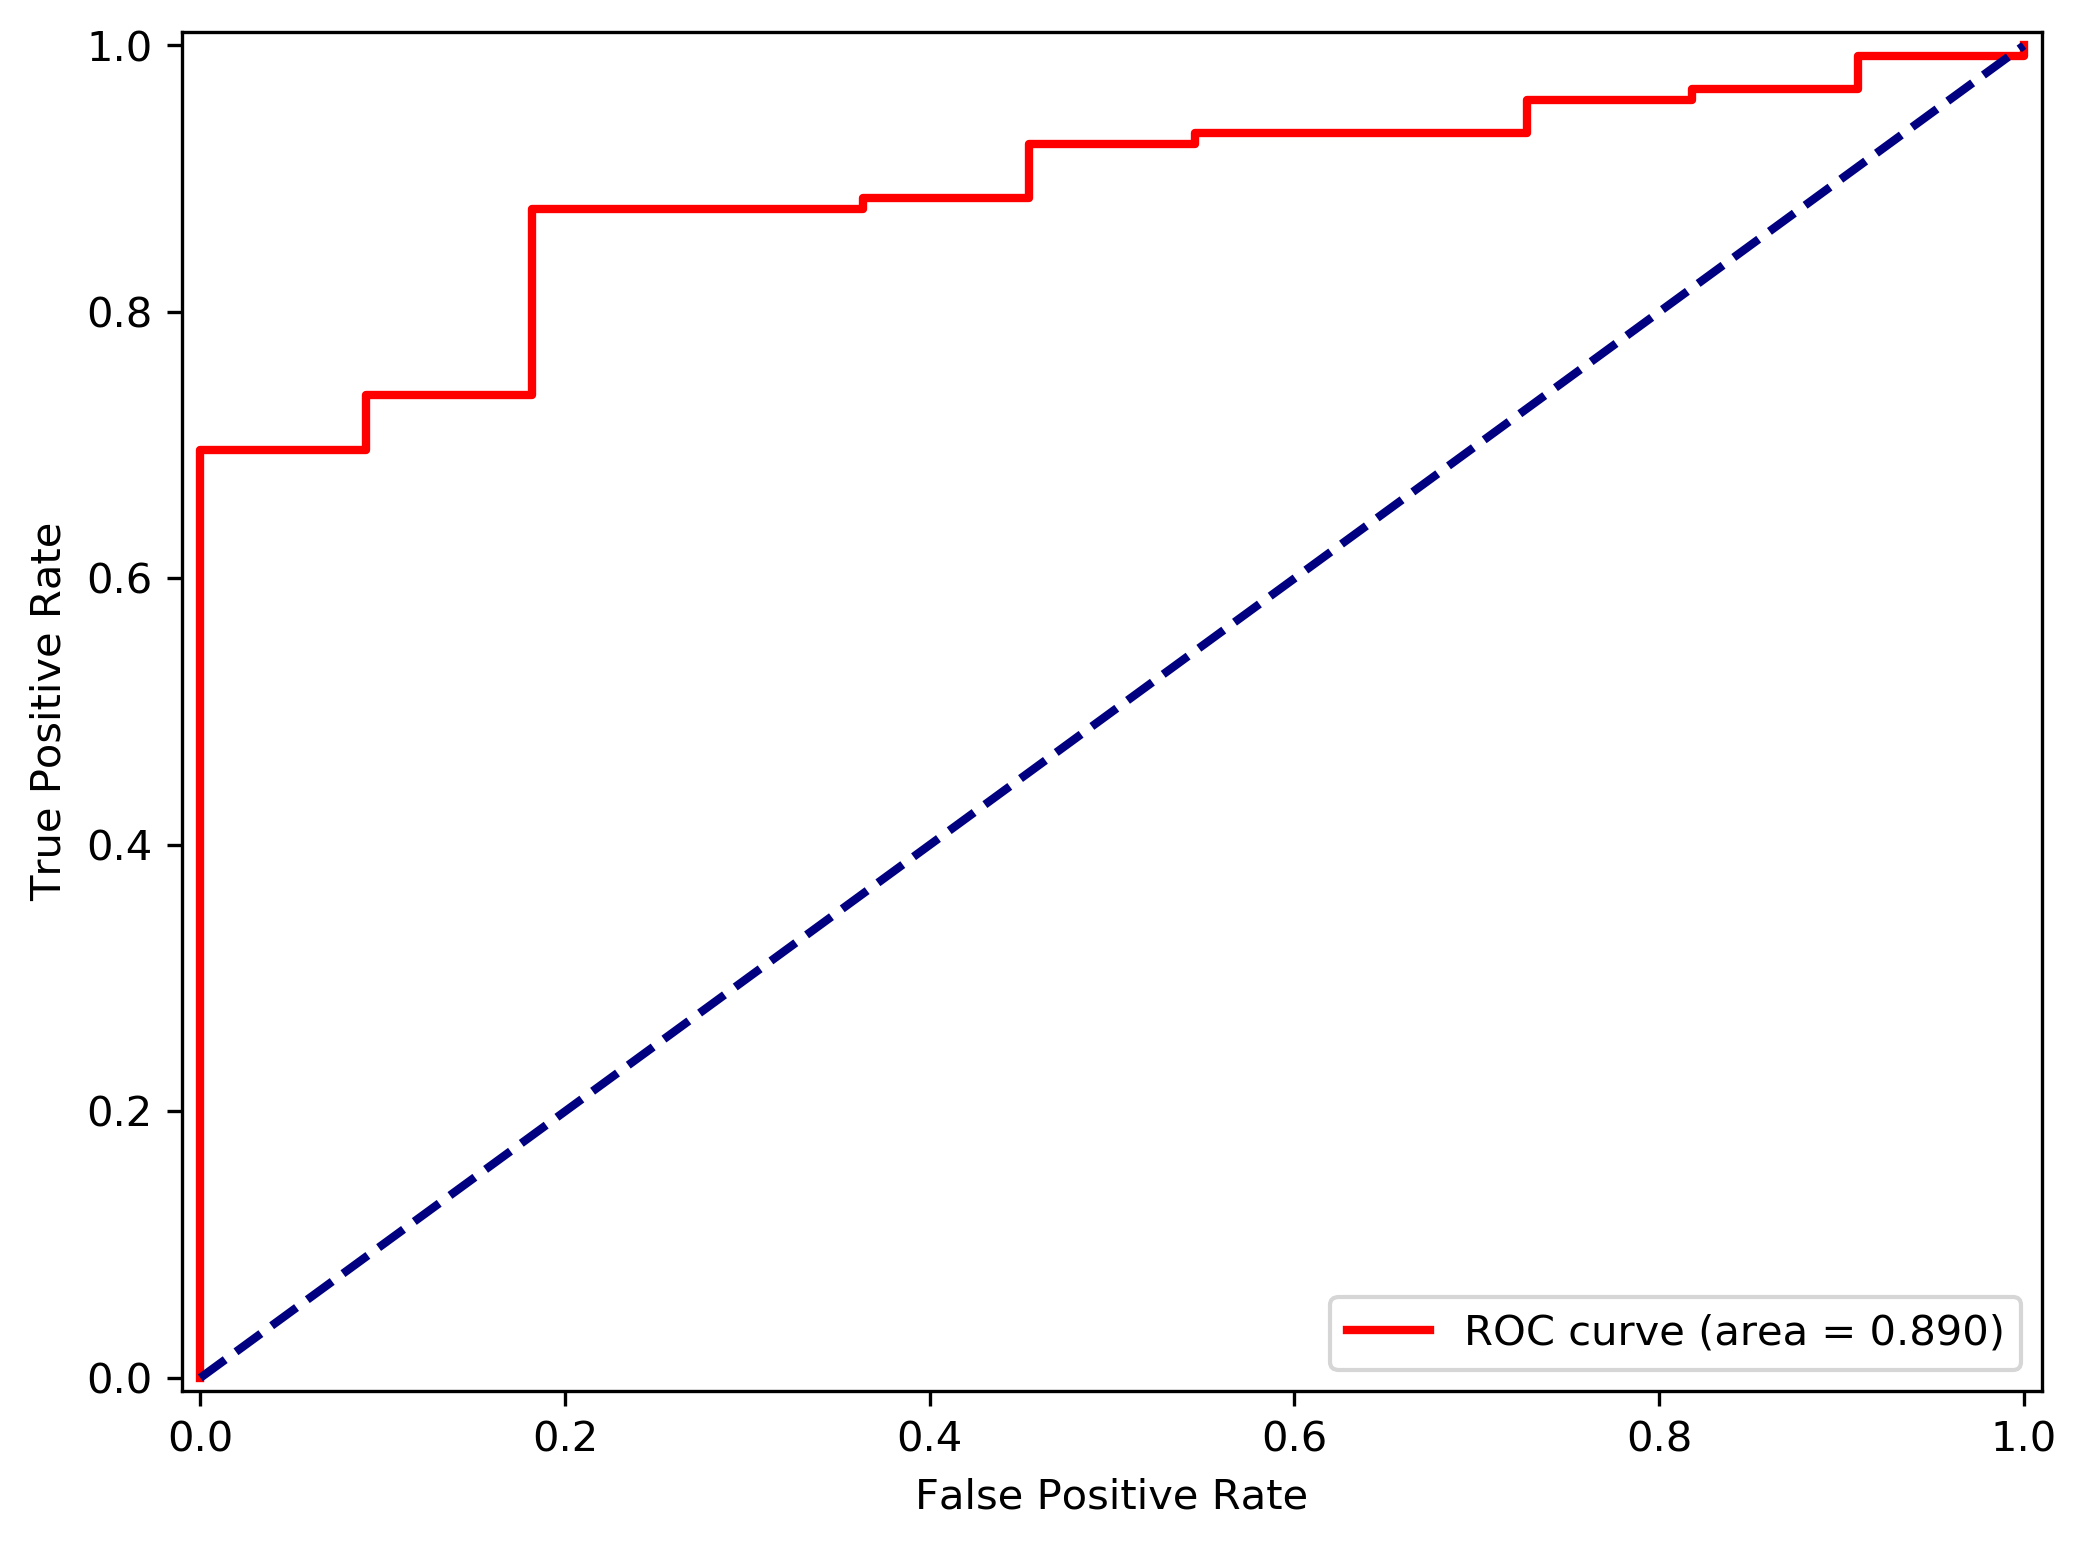

In [14]:
from sklearn import metrics
pred, probs = trainer.predict(model, extenal_data_loader)[0]

fpr, tpr, thresholds = metrics.roc_curve(y_extenal, probs.numpy(), pos_label=1)
auc = metrics.auc(fpr, tpr)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = plt.plot(fpr, tpr, color="red", lw=2, label="ROC curve (area = %0.3f)" % auc)
_ = plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
_ = plt.xlim([-0.01, 1.01])
_ = plt.ylim([-0.01, 1.01])
_ = plt.xlabel("False Positive Rate")
_ = plt.ylabel("True Positive Rate")
_ = plt.legend(loc="lower right")
_ = plt.show()
fig.savefig('20220610_Results/7. ROC_extend_mean.pdf', dpi=300)

<Figure size 2400x1800 with 0 Axes>

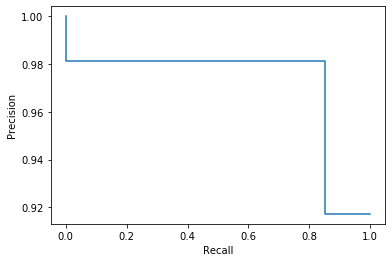

In [15]:
precision, recall, _ = metrics.precision_recall_curve(y_extenal, pred.numpy())
disp = metrics.PrecisionRecallDisplay(precision=precision, recall=recall)
fig = plt.figure(figsize=(8, 6), dpi=300)
_ = disp.plot()